## Read the data first

In [64]:
from pathlib import Path

import pandas as pd

df = pd.read_csv(Path('../../results/repository_evolution_0-4920_MERGED.csv'))
df_commits = pd.read_csv(Path('../../data/huggingface_sort_by_createdAt_top996939_commits_0_1035.csv'))

# grabs the date from df2 and adds it to df based on commit_hash and repo_url matching, implementation needs to be efficient
def add_date_to_df(df, df_commits):
    df['date'] = ""
    for index, row in df.iterrows():
        commit_hash = row['commit_hash']
        repo_url = row['repo_url']
        matched_row = df_commits.loc[
            (df_commits['commit_hash'] == commit_hash) & 
            (df_commits['repo_url'] == repo_url)
        ]
        
        df.at[index, 'date'] = matched_row['date'].values[0]
        df.at[index, 'message'] = matched_row['message'].values[0]
    return df

df = add_date_to_df(df, df_commits)
df['date'] = pd.to_datetime(df['date'])

# Reference date when safetensors was released
reference_date = pd.to_datetime("2022-09-23")

# Calculate elapsed days since reference date
df['elapsed_days'] = (df['date'] - reference_date).dt.days
df

,repo_url,commit_hash,model_file_path,serialization_format,date,message,elapsed_days
0,stanfordnlp/stanza-ja,982d65055e3f5cdaef4f8b0a188e2db9ae528888,stanfordnlp/stanza-ja/models/backward_charlm/c...,pickle,2022-04-21 10:32:52,Add model 1.3.1,-155
1,stanfordnlp/stanza-ja,982d65055e3f5cdaef4f8b0a188e2db9ae528888,stanfordnlp/stanza-ja/models/constituency/alt.pt,pickle,2022-04-21 10:32:52,Add model 1.3.1,-155
2,stanfordnlp/stanza-ja,982d65055e3f5cdaef4f8b0a188e2db9ae528888,stanfordnlp/stanza-ja/models/forward_charlm/co...,pickle,2022-04-21 10:32:52,Add model 1.3.1,-155
3,stanfordnlp/stanza-ja,9fb4707cefdb1e19cd68c00539eb444320483a83,stanfordnlp/stanza-ja/models/constituency/alt.pt,pickle,2022-04-06 23:58:23,Add model 1.3.1,-170
4,stanfordnlp/stanza-ja,83625a4bf73f4ba466e189669b96b973c5f021a3,stanfordnlp/stanza-ja/models/constituency/alt.pt,pickle,2022-04-05 00:09:23,Add model 1.3.1,-171
...,...,...,...,...,...,...,...
7542,deepparag/Aeona,8b7237d36a122823697c669251052a4c39b591c0,deepparag/Aeona/pytorch_model.bin,torch.save,2022-04-08 07:56:56,add model,-168
7543,deepparag/Aeona,33bd87ef27c71a2385547b0b2e2945eff9f40e92,deepparag/Aeona/pytorch_model.bin,torch.save,2022-04-08 06:13:00,add model,-168
7544,deepparag/Aeona,e593b84a2a396160164bcc3a05dbd85a662b6160,deepparag/Aeona/pytorch_model.bin,torch.save,2022-04-08 03:53:51,add model,-168
7545,deepparag/Aeona,234d7f06d418da8703ccb3561aea40d7ff160df9,deepparag/Aeona/pytorch_model.bin,torch.save,2022-04-08 02:09:35,add model,-168


## RQ1 How long it took developers to adopt safetensors after its first release?
    We know the date when safetensors was released, however we do not currently have an understanding of how fast safetensors was adopted as a serialization format for models. In this question, we aim to understand when people begun using safetensors in their repositories.    

### Analysis 1: Number of elapsed days since the release of safetensors
Compute the number of model files added/changed over time since the release of safetensors.

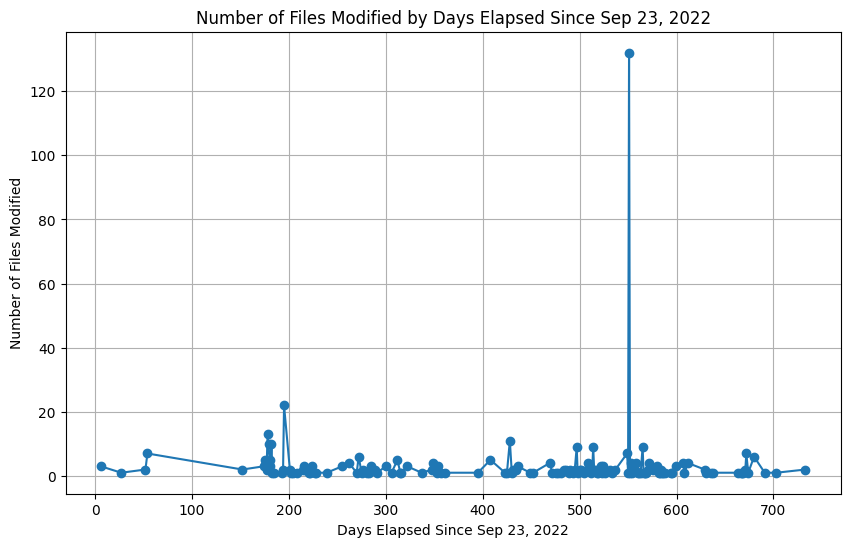

In [59]:
import matplotlib.pyplot as plt

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']

# Group by elapsed days to count files modified on each date
files_modified_by_day = df_safetensors['elapsed_days'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(files_modified_by_day.index, files_modified_by_day.values, marker='o', linestyle='-')
plt.xlabel("Days Elapsed Since Sep 23, 2022")
plt.ylabel("Number of Files Modified")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()


### Analysis 2: Number of elapsed days since safetensors first appearead in a repo


Number of analyzed repos:  1024
Number of repos without safetensors: 612
Number of repos using safe tensors 412
(min, quartile2, median, quartile4, max) (6, 224.0, 513.5, 551.0, 733)


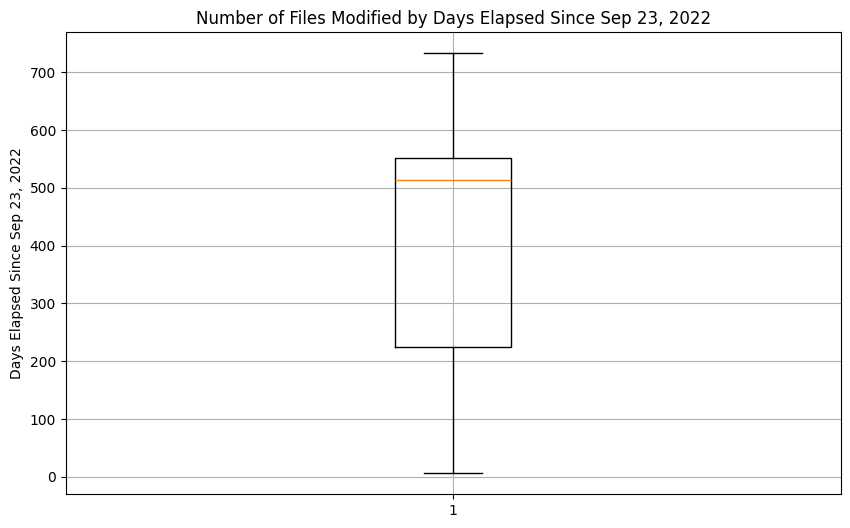

In [93]:
import matplotlib.pyplot as plt

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']


# find the lowest number of elapsed days per unique repo_url
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()

df_safetensors_first_appearance
min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos wihout safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("(min, quartile2, median, quartile4, max)",(min, quartile2, median, quartile4, max))

# show box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_safetensors_first_appearance['elapsed_days'])
plt.ylabel("Days Elapsed Since Sep 23, 2022")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()

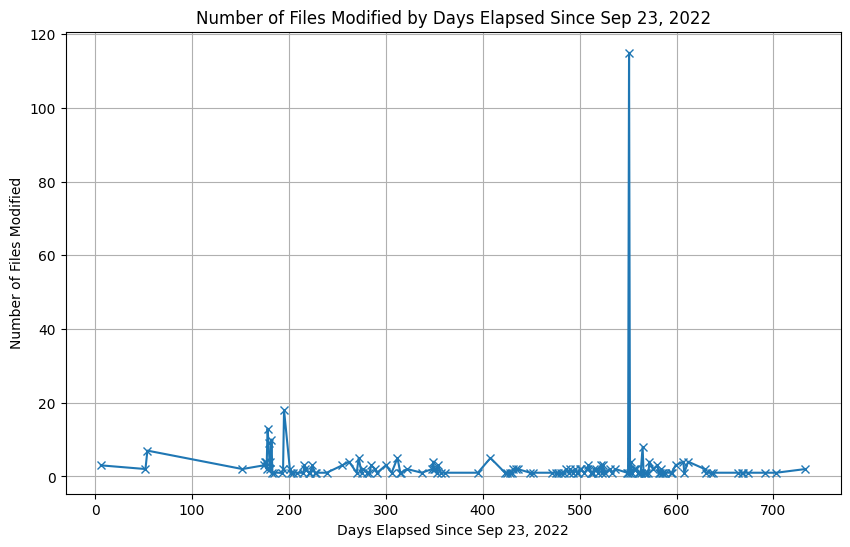

In [72]:
# plot files_modified_by_day
plt.figure(figsize=(10, 6))
plt.plot(df_safetensors_first_appearance.index, df_safetensors_first_appearance.values, marker='x', linestyle='-')
plt.xlabel("Days Elapsed Since Sep 23, 2022")
plt.ylabel("Number of Files Modified")
plt.title("Number of Files Modified by Days Elapsed Since Sep 23, 2022")
plt.grid(True)
plt.show()


## RQ2 

### Visualization of serialization format over the years

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Sample data
df_by_date = df[['date', 'serialization_format']]

# Convert the 'date' column to datetime and extract the year
df_by_date['date'] = pd.to_datetime(df_by_date['date'])
df_by_date.loc[:, 'year'] = df_by_date['date'].dt.year

# Group by year and serialization format, then count occurrences
grouped = df_by_date.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

# Cumulative values for stacked bars
cumulative_values = np.zeros(len(grouped_percentage))

for serialization_format in grouped_percentage.columns:
    ax.bar(grouped_percentage.index, grouped_percentage[serialization_format], 
           bottom=cumulative_values, label=serialization_format)
    cumulative_values += grouped_percentage[serialization_format]

# Add labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
ax.set_title('100% Stacked Serialization Format Distribution Over Years')
# ax.legend(title='Serialization Format')
# Move the legend outside of the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])


plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# Group by year and serialization format, then count occurrences
grouped = df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 4)) 

# Plot lines for each serialization format
for serialization_format in grouped_percentage.columns:
    ax.plot(grouped_percentage.index, grouped_percentage[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Distribution Over Years')
# ax.legend(title='Serialization Format')
# Move the legend outside of the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rectangle to fit the legend

plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# Filter out rows with 'undetermined' serialization format
filtered_df = df[df['serialization_format'] != 'undetermined']
# Group by year and serialization format, then count occurrences
grouped_counts = filtered_df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Set the size of the figure (width, height)
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust width and height as needed

# Plot the line chart with counts
for serialization_format in grouped_counts.columns:
    ax.plot(grouped_counts.index, grouped_counts[serialization_format], marker='o', label=serialization_format)

# Add labels and title
ax.set_ylabel('# Model Files')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Totals Over Years')

# Move the legend outside of the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()
